In [ ]:
import torch
from torch import nn
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split

```SKConv```

The ```SKConv``` class defines a selective kernel convolution operation. It takes input features, input spatial dimensions (WH), the number of branches (M), the number of convolution groups (G), the radio for computing d (r), stride, and the minimum dimension of the vector z (L).
It contains a set of convolutional layers with varying kernel sizes and groups.
It uses global average pooling to generate channel-wise statistics, followed by a fully connected layer to obtain a compact feature vector z.
Softmax is applied to calculate attention vectors, and the final output is obtained by aggregating feature maps based on these attention vectors.

(1) Split:

The Split operation is implemented by creating multiple paths with various kernel sizes and then iterating over the specified number of branches (M). For each branch, a convolutional layer is applied with a kernel size that varies based on the branch index. The convolutional layers have different kernel sizes and are grouped into the specified number of convolution groups (G). Batch normalization and ReLU activation follow each convolution operation. Split creates different views of the input using convolutional layers with various kernel sizes and groups and each view captures different details in the input data.

(2) Fuse:

The Fuse operation combines and aggregates information from different views into a comprehensive representation. After the Split operation, the feature maps from different branches are aggregated using an element-wise summation in the Fuse operation. The resulting tensor is denoted as fea_U. Global average pooling is then applied to fea_U to generate channel-wise statistics (s), capturing the characteristics of the combined information from Split.

(3) Select: 

The Select operation ues a fully connected layer to generate a compact feature vector based on the global information.
A fully connected layer (fc) is used to obtain a compact feature vector z from the channel-wise statistics (s).
Each branch is iterated oven and an fc is applied to the compact feature vector z to obtain attention vectors. Softmax is applied to create attention vectors that determine the importance of each view. The final feature map (fea_v) is obtained by multiplying the original feature maps from each branch by their corresponding attention weights and summing the results.

In [8]:
class SKConv(nn.Module):
    def __init__(self, features, WH, M, G, r, stride=1 ,L=32):
        """ Constructor
        Args:
            features: input channel dimensionality.
            WH: input spatial dimensionality, used for GAP kernel size.
            M: the number of branchs.
            G: num of convolution groups.
            r: the radio for compute d, the length of z.
            stride: stride, default 1.
            L: the minimum dim of the vector z in paper, default 32.
        """
        super(SKConv, self).__init__()
        d = max(int(features/r), L)
        self.M = M
        self.features = features
        self.convs = nn.ModuleList([])
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3+i*2, stride=stride, padding=1+i, groups=G),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=False)
            ))
        self.fc = nn.Linear(features, d)
        self.fcs = nn.ModuleList([])
        for i in range(M):
            self.fcs.append(
                nn.Linear(d, features)
            )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        for i, conv in enumerate(self.convs):
            fea = conv(x)
            fea = fea.unsqueeze(dim=1)
            if i == 0:
                feas = fea
            else:
                feas = torch.cat([feas, fea], dim=1)
        fea_U = torch.sum(feas, dim=1)
        fea_s = fea_U.mean(-1).mean(-1)
        fea_z = self.fc(fea_s)
        for i, fc in enumerate(self.fcs):
            vector = fc(fea_z).unsqueeze_(dim=1)
            if i == 0:
                attention_vectors = vector
            else:
                attention_vectors = torch.cat([attention_vectors, vector], dim=1)
        attention_vectors = self.softmax(attention_vectors)
        attention_vectors = attention_vectors.unsqueeze(-1).unsqueeze(-1)
        fea_v = (feas * attention_vectors).sum(dim=1)
        return fea_v


```SKUnit```:

```SKUnit``` defines a residual block containing an ```SKConv``` module. It takes input and output channel dimensions, input spatial dimensions (WH), the number of branches (M), the number of convolution groups (G), the radio for computing d (r), stride, and the minimum dimension of the vector z (L).
It consists of a sequence of 1x1 convolutions, SK convolution, and another 1x1 convolution. It includes a shortcut connection if the input and output dimensions are the same.

In [ ]:
class SKUnit(nn.Module):
    def __init__(self, in_features, out_features, WH, M, G, r, mid_features=None, stride=1, L=32):
        """ Constructor
        Args:
            in_features: input channel dimensionality.
            out_features: output channel dimensionality.
            WH: input spatial dimensionality, used for GAP kernel size.
            M: the number of branchs.
            G: num of convolution groups.
            r: the radio for compute d, the length of z.
            mid_features: the channle dim of the middle conv with stride not 1, default out_features/2.
            stride: stride.
            L: the minimum dim of the vector z in paper.
        """
        super(SKUnit, self).__init__()
        if mid_features is None:
            mid_features = int(out_features/2)
        self.feas = nn.Sequential(
            nn.Conv2d(in_features, mid_features, 1, stride=1),
            nn.BatchNorm2d(mid_features),
            SKConv(mid_features, WH, M, G, r, stride=stride, L=L),
            nn.BatchNorm2d(mid_features),
            nn.Conv2d(mid_features, out_features, 1, stride=1),
            nn.BatchNorm2d(out_features)
        )
        if in_features == out_features: # when dim not change, in could be added diectly to out
            self.shortcut = nn.Sequential()
        else: # when dim not change, in should also change dim to be added to out
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride=stride),
                nn.BatchNorm2d(out_features)
            )
    
    def forward(self, x):
        fea = self.feas(x)
        return fea + self.shortcut(x)

The ```SKNet``` class defines the structure of the SKNet framework. It takes the number of classes and kernel size as inputs. The network consists of three stages, each containing multiple ```SKUnits```. In ```forward```, input data goes through basic convolution, followed by the three stages of ```SKUnits```. The process involves global average pooling, linear layers, and softmax to produce class predictions.

In [ ]:
class SKNet(nn.Module):
    def __init__(self, class_num, kernel_size):
        super(SKNet, self).__init__()
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size, padding=int((kernel_size-1)/2)),
            nn.BatchNorm2d(64)
        )
        self.stage_1 = nn.Sequential(
            SKUnit(64, 256, 32, 2, 8, 2, stride=2),
            nn.ReLU(),
            SKUnit(256, 256, 32, 2, 8, 2),
            nn.ReLU(),
            SKUnit(256, 256, 32, 2, 8, 2),
            nn.ReLU()
        ) # 32x32
        self.stage_2 = nn.Sequential(
            SKUnit(256, 512, 32, 2, 8, 2, stride=2),
            nn.ReLU(),
            SKUnit(512, 512, 32, 2, 8, 2),
            nn.ReLU(),
            SKUnit(512, 512, 32, 2, 8, 2),
            nn.ReLU()
        ) # 16x16
        self.stage_3 = nn.Sequential(
            SKUnit(512, 1024, 32, 2, 8, 2, stride=2),
            nn.ReLU(),
            SKUnit(1024, 1024, 32, 2, 8, 2),
            nn.ReLU(),
            SKUnit(1024, 1024, 32, 2, 8, 2),
            nn.ReLU()
        ) # 8x8
        self.pool = nn.AvgPool2d(4)
        self.classifier = nn.Sequential(
            nn.Linear(1024, class_num),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        fea = self.basic_conv(x)
        fea = self.stage_1(fea)
        fea = self.stage_2(fea)
        fea = self.stage_3(fea)
        fea = fea.float()
        fea = self.pool(fea)
        fea = torch.squeeze(fea)
        fea = self.classifier(fea)
        return fea

```load_images_with_labels()``` loads images from directory, converts them to RGB format, normalizes pixel values, and associates them with a given label. The labels are provided as an argument to the function. The loaded image-label pairs are then appended to a list, and the final list is returned. This is used to plot the original image against the transformed image.

In [2]:
def load_images_with_labels(directory_path, label):
    data_with_labels = []

    for image_path in os.listdir(directory_path):
        if image_path.lower().endswith('.mhd'):
            full_path = os.path.join(directory_path, image_path)
            image = sitk.ReadImage(full_path)
            image_array = sitk.GetArrayFromImage(image)

            # Normalize pixel values to [0, 255]
            image_array_normalized = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)
            
            # Convert to RGB
            image_rgb = Image.fromarray(image_array_normalized).convert('RGB')

            # Append the tuple to the list
            data_with_labels.append((image_rgb, label))

    return data_with_labels

# Load images with label 1
healthy_data = load_images_with_labels('./data/training/healthy/', label=1)

# Load images with label 0
diseased_data = load_images_with_labels('./data/training/diseased/', label=0)



```ImageDataset()```

```__init__``` Method:

* Initializes the dataset using directory path, label, and data transformation.
* Converts images RGB format, and normalizes pixel values
* Creates a list data_with_labels that has the RGB images and their corresponding label

```__len__``` Method:

Returns the total number of samples

```__getitem__``` Method:

* Retrieves an image-label pair at index
* Applies tranformation
    * Test Transformation:
        * Resize the image to (32, 32).
        * Convert the image to a PyTorch tensor
        * Normalize the pixel values to a range of [-1, 1]
        
    * Train Transformation:
        * Resize the image to (32, 32).
        * Apply random horizontal flip, rotation, affine transformations, and color jitter.
        * Convert the image to a PyTorch tensor.
        * Normalize the pixel values to a range of [-1, 1].

* Returns the transformed image and its label
* Creates PyTorch DataLoader objects (train_loader and test_loader) for batch processing during training and testing

In [14]:
class ImageDataset(Dataset):
    def __init__(self, directory_path, label, transform=None):
        self.data_with_labels = []
        self.label = label
        self.transform = transform

        for image_path in os.listdir(directory_path):
            if image_path.lower().endswith('.mhd'):
                full_path = os.path.join(directory_path, image_path)
                image = sitk.ReadImage(full_path)
                image_array = sitk.GetArrayFromImage(image)

                # Normalize pixel values to [0, 255]
                image_array_normalized = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)

                # Convert to RGB
                image_rgb = Image.fromarray(image_array_normalized.squeeze(), 'L').convert('RGB')

                # Append the tuple to the list
                self.data_with_labels.append((image_rgb, label))

    def __len__(self):
        return len(self.data_with_labels)

    def __getitem__(self, index):
        image, label = self.data_with_labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create training dataset
train_dataset_healthy = ImageDataset('./data/training/healthy/', label=1, transform=transform_train)
train_dataset_diseased = ImageDataset('./data/training/diseased/', label=0, transform=transform_train)
train_dataset = torch.utils.data.ConcatDataset([train_dataset_healthy, train_dataset_diseased])

# Create testing dataset
test_dataset_healthy = ImageDataset('./data/testing/healthy/', label=1, transform=transform_test)
test_dataset_diseased = ImageDataset('./data/testing/diseased/', label=0, transform=transform_test)
test_dataset = torch.utils.data.ConcatDataset([test_dataset_healthy, test_dataset_diseased])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


```plot_transformed_vs_orginal()``` Plots original image against transformed image

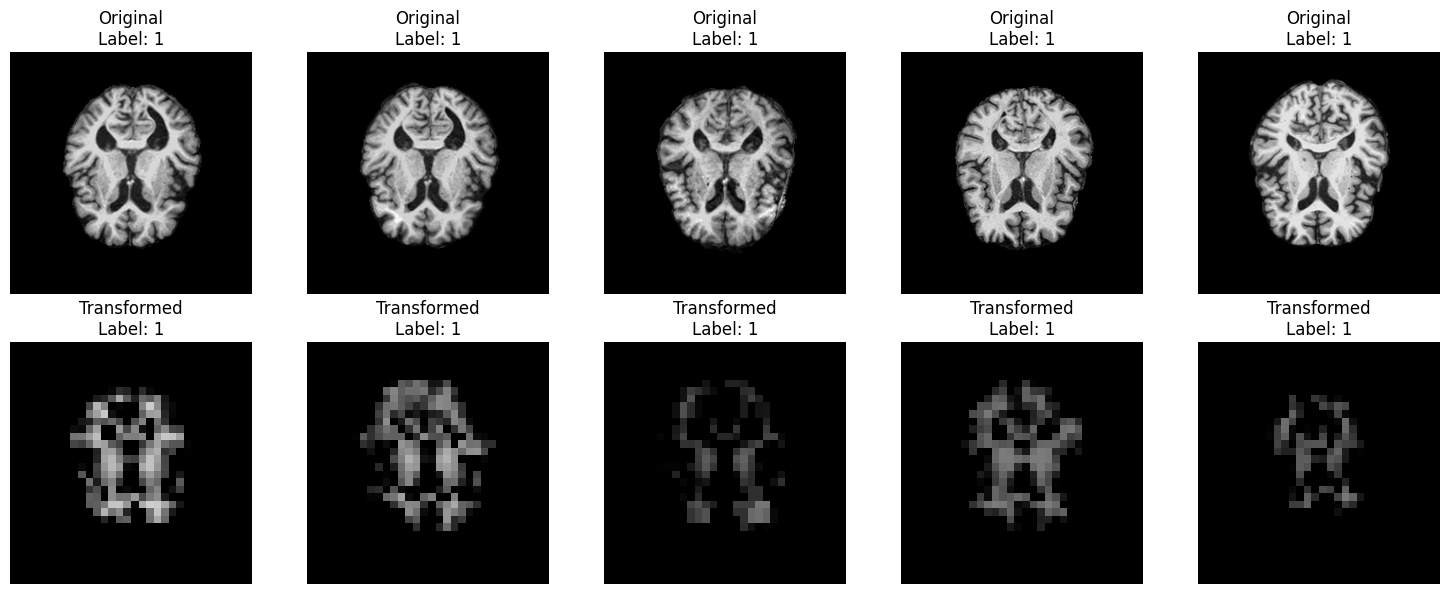

In [13]:
def plot_transformed_vs_orginal(train_loader, original_image, num_display_images=5):
    # Load a batch from the train loader
    batch_images, batch_labels = next(iter(train_loader))

    plt.figure(figsize=(15, 6))

    for i in range(num_display_images):
        plt.subplot(2, num_display_images, i + 1)
        original_img = original_image[i][0]
        plt.imshow(np.clip(original_img, 0, 255), cmap='viridis')  # Clip the values to [0, 255]
        plt.title(f"Original\nLabel: {original_image[i][1]}")
        plt.axis('off')
        
        # Plot transformed image
        plt.subplot(2, num_display_images, num_display_images + i + 1)
        transformed_image = batch_images[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(transformed_image, 0, 1), cmap='gray')  # Clip the values to [0, 1]
        plt.title(f'Transformed\nLabel: {batch_labels[i]}')
        plt.axis('off')

    plt.tight_layout()  
    plt.show()

train_loader_healthy = DataLoader(train_dataset_healthy, batch_size=5, shuffle=True)
display_images_with_transformed(train_loader_healthy, original_image=healthy_data)


**Implementation Overview**

```train_losses, train_accuracies, test_losses, test_accuracies```: Lists that stores training and testing metrics

```num_display_images```: # of images to show when plotting predictions/labels

```kernel_sizes```: Diff kernel sizes to test

```kernel_results```: Dictionary to store results (loss, accuracy, predictions) for each kernel size 

For each kernel size and for each specified epoch,

**(1)** Initialize an SKNet model

**(2)** Train model using ```train_epoch()``` and store results in kernel_results

**(3)** Test the model using ```test()``` and store results in kernel_results.

**Assessment**

**(1)** Plot training and testing metrics for each kernel size

**(2)** Plot accuracy for best kernel size for test and training

**(3)** Plot first 5 test/train images and corresponding prediction/label from best kernel size

epoch 0, average loss 0.021118389296641546, training accuracy 0.6221198156682027
epoch 0, test loss 0.018150734901428222, test accuracy [12/50]
epoch 1, average loss 0.014450199043695829, training accuracy 0.5806451612903226
epoch 1, test loss 0.012559341192245483, test accuracy [38/50]
epoch 2, average loss 0.014825809935820267, training accuracy 0.576036866359447
epoch 2, test loss 0.023810458183288575, test accuracy [12/50]
epoch 3, average loss 0.016851109568424488, training accuracy 0.5161290322580645
epoch 3, test loss 0.011060874462127685, test accuracy [38/50]
epoch 4, average loss 0.012868281883028795, training accuracy 0.5161290322580645
epoch 4, test loss 0.011055032014846802, test accuracy [38/50]
epoch 5, average loss 0.015363646817097466, training accuracy 0.511520737327189
epoch 5, test loss 0.015978678464889526, test accuracy [12/50]
epoch 6, average loss 0.013592004501325194, training accuracy 0.6036866359447005
epoch 6, test loss 0.011459115743637085, test accuracy [3

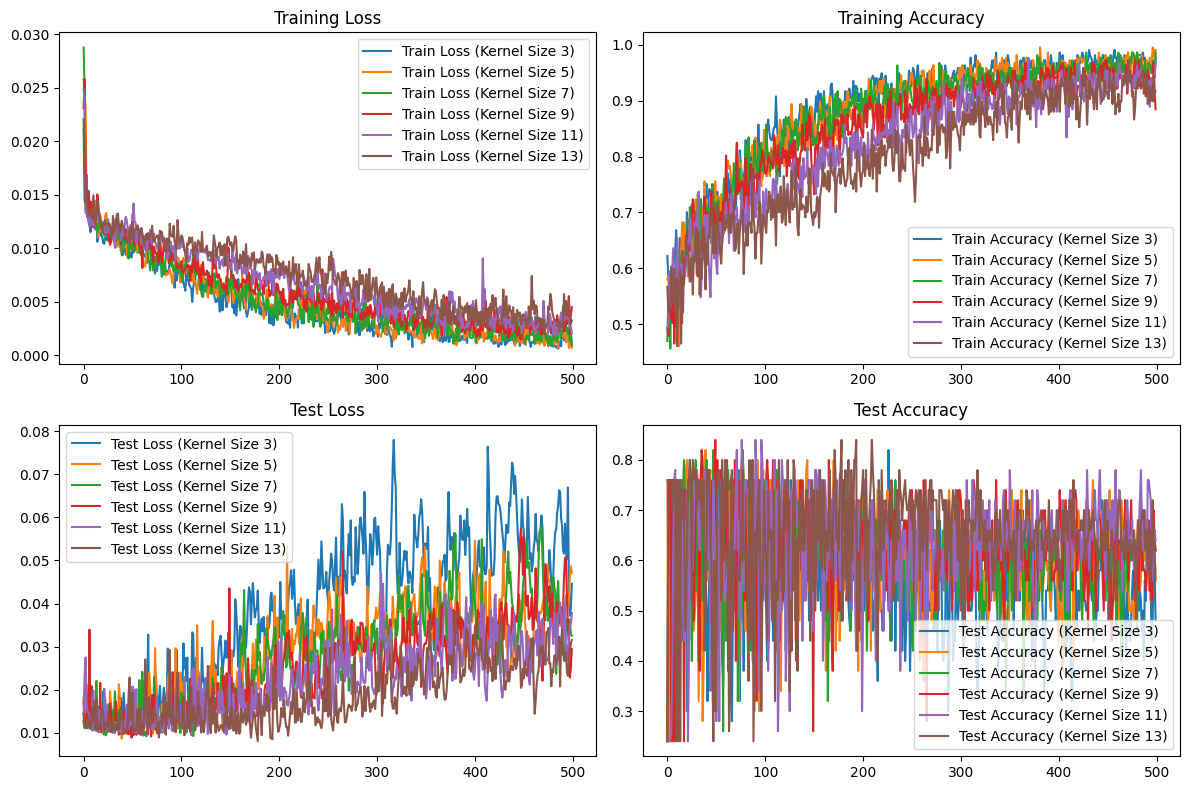

In [5]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_display_images = 5 

kernel_sizes = [3, 5, 7, 9, 11, 13]
kernel_results = {k: {'train_losses': [], 'train_accuracies': [], 'train_predictions': [], 'train_labels': [], 'train_images': [],
                      'test_losses': [], 'test_accuracies': [], 'test_predictions': [], 'test_labels': [], 'test_images': [],
                      'epochs': []} for k in kernel_sizes}

def test(model, test_loader, criterion, epoch, kernel_size, writer=None):
    model.eval()
    test_loss = 0
    correct = 0
    
    display_test_images = []
    display_test_labels = []
    display_test_predictions = []

    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            data = data.cuda()
            label = label.cuda()
            result = model(data)
            test_loss += criterion(result, label).item()
            pred = result.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
            # Store test predictions for the first batch
            if i == 0:
                display_test_images.append(data.cpu().numpy())
                display_test_labels.append(label.cpu().numpy())
                display_test_predictions.append(pred.cpu().numpy())

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_accuracy = correct / len(test_loader.dataset)
    kernel_results[kernel_size]['test_losses'].append(epoch_test_loss)
    kernel_results[kernel_size]['test_accuracies'].append(epoch_test_accuracy)
    
    print('epoch {}, test loss {}, test accuracy [{}/{}]'.format(epoch, epoch_test_loss, correct, len(test_loader.dataset)))
    
    if epoch % 1 == 0:  
        display_test_images = np.concatenate(display_test_images, axis=0)
        display_test_labels = np.concatenate(display_test_labels, axis=0)
        display_test_predictions = np.concatenate(display_test_predictions, axis=0)
        display_test_labels = [arr.ravel() for arr in display_test_labels]
        display_test_predictions = [arr.ravel() for arr in display_test_predictions]

        # store results
        kernel_results[kernel_size]['test_images'].append(display_test_images)
        kernel_results[kernel_size]['test_labels'].append(display_test_labels)
        kernel_results[kernel_size]['test_predictions'].append(display_test_predictions)
        kernel_results[kernel_size]['epochs'].append(epoch)

def train_epoch(model, optimizer, train_loader, criterion, epoch, kernel_size, writer=None):
    model.train()
    num = len(train_loader)
    total_loss = 0
    correct = 0
    total_samples = 0

    # Store images and predictions for visualization
    display_images = []
    display_labels = []
    display_predictions = []

    for i, (data, label) in enumerate(train_loader):
        model.zero_grad()
        optimizer.zero_grad()
        data = data.cuda()
        label = label.cuda().long()
        result = model(data)

        loss = criterion(result, label)
        total_loss += loss.item()

        pred = result.argmax(dim=1)
        correct += pred.eq(label).sum().item()
        total_samples += len(label)

        if i == 0:
            display_images.append(data.cpu().numpy())
            display_labels.append(label.cpu().numpy())
            display_predictions.append(pred.cpu().numpy())

        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct / total_samples
    kernel_results[kernel_size]['train_losses'].append(epoch_loss)
    kernel_results[kernel_size]['train_accuracies'].append(epoch_accuracy)

    print('epoch {}, average loss {}, training accuracy {}'.format(epoch, epoch_loss, epoch_accuracy))

    if epoch % 1 == 0:  
        display_images = np.concatenate(display_images, axis=0)
        display_labels = np.concatenate(display_labels, axis=0)
        display_predictions = np.concatenate(display_predictions, axis=0)

        # Store in kernel_results
        kernel_results[kernel_size]['train_images'].append(display_images)
        kernel_results[kernel_size]['train_labels'].append(display_labels)
        kernel_results[kernel_size]['train_predictions'].append(display_predictions)
        kernel_results[kernel_size]['epochs'].append(epoch)

num_epochs = 500

for kernel_size in kernel_sizes:
    model = SKNet(class_num=2, kernel_size=kernel_size)
    model.cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_epoch(model, optimizer, train_loader, criterion, epoch, kernel_size)

        test(model, test_loader, criterion, epoch, kernel_size)

plt.figure(figsize=(12, 8))

for kernel_size, results in kernel_results.items():
    plt.subplot(2, 2, 1)
    plt.plot(results['train_losses'], label=f'Train Loss (Kernel Size {kernel_size})')
    plt.legend()
    plt.title('Training Loss')

    plt.subplot(2, 2, 2)
    plt.plot(results['train_accuracies'], label=f'Train Accuracy (Kernel Size {kernel_size})')
    plt.legend()
    plt.title('Training Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(results['test_losses'], label=f'Test Loss (Kernel Size {kernel_size})')
    plt.legend()
    plt.title('Test Loss')

    plt.subplot(2, 2, 4)
    plt.plot(results['test_accuracies'], label=f'Test Accuracy (Kernel Size {kernel_size})')
    plt.legend()
    plt.title('Test Accuracy')

plt.tight_layout()
plt.show()


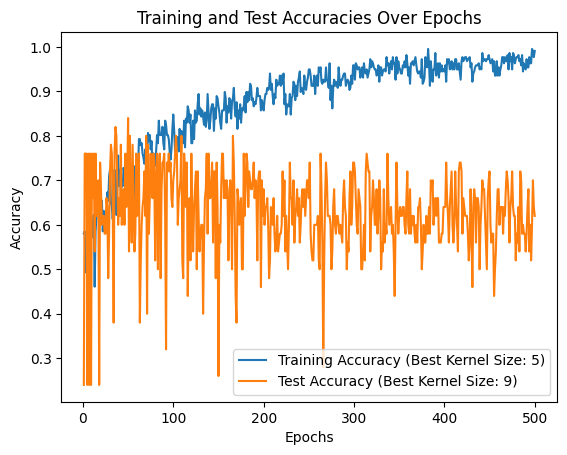

In [6]:
best_kernel_size_test = max(kernel_results, key=lambda k: max(kernel_results[k]['test_accuracies']))
best_kernel_size_train = max(kernel_results, key=lambda k: max(kernel_results[k]['train_accuracies']))

# Extract training and test accuracies for the best kernel size
best_kernel_results_test = kernel_results[best_kernel_size_test]
best_kernel_results_train = kernel_results[best_kernel_size_train]

train_accuracies = best_kernel_results_train['train_accuracies']
test_accuracies = best_kernel_results_test['test_accuracies']

# Plot training and test accuracies over epochs
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, label=f'Training Accuracy (Best Kernel Size: {best_kernel_size_train})')
plt.plot(epochs, test_accuracies, label=f'Test Accuracy (Best Kernel Size: {best_kernel_size_test})')

plt.title('Training and Test Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

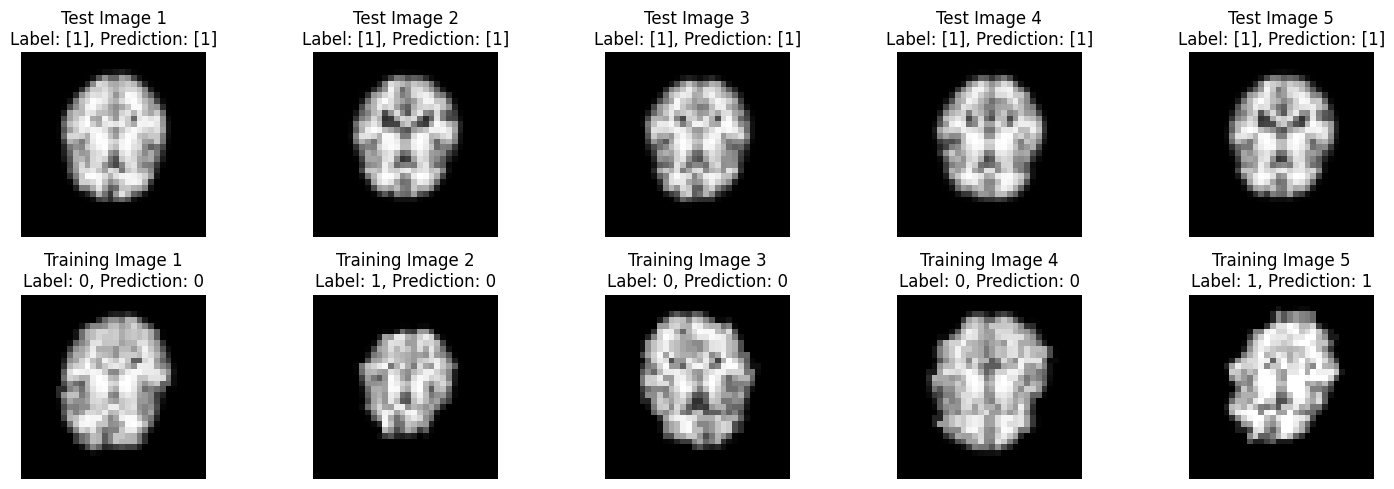

In [7]:
# Find the kernel size with the best test accuracy
best_kernel_size = max(kernel_results, key=lambda k: max(kernel_results[k]['test_accuracies']))

# Get the results for the best kernel size
best_results = kernel_results[best_kernel_size]

# Find the epoch with the highest test accuracy
best_epoch = best_results['epochs'][np.argmax(best_results['test_accuracies'])]

# Get the predictions, labels, and images for the best epoch
best_test_predictions = best_results['test_predictions'][best_epoch]
best_test_labels = best_results['test_labels'][best_epoch]
best_test_images = best_results['test_images'][best_epoch]

# Plot the first 5 test images
num_display_images = 5

plt.figure(figsize=(15, 5))
for i in range(num_display_images):
    plt.subplot(2, num_display_images, i + 1)
    plt.imshow(best_test_images[i, 0, :, :], cmap='gray')
    plt.title(f"Test Image {i + 1}\nLabel: {best_test_labels[i]}, Prediction: {best_test_predictions[i]}")
    plt.axis('off')

# Find the kernel size with the best training accuracy
best_train_kernel_size = max(kernel_results, key=lambda k: max(kernel_results[k]['train_accuracies']))

# Get the results for the best training kernel size
best_train_results = kernel_results[best_train_kernel_size]

# Find the epoch with the highest training accuracy
best_train_epoch = best_train_results['epochs'][np.argmax(best_train_results['train_accuracies'])]

# Get the training predictions, labels, and images for the best epoch
best_train_predictions = best_train_results['train_predictions'][best_train_epoch]
best_train_labels = best_train_results['train_labels'][best_train_epoch]
best_train_images = best_train_results['train_images'][best_train_epoch]

# Plot the first 5 training images
for i in range(num_display_images):
    plt.subplot(2, num_display_images, i + num_display_images + 1)
    plt.imshow(best_train_images[i, 0, :, :], cmap='gray')
    plt.title(f"Training Image {i + 1}\nLabel: {best_train_labels[i]}, Prediction: {best_train_predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

